In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
from sklearn.metrics import mean_squared_error


In [62]:
# Create a discrete colormap with 4 colors (one for each network architecture)
arch_names = ['g_true', 'FF', 'PI-FF', 'DGM', 'PI-DGM']
batlow_colors = cmc.batlow(np.linspace(0, 1, len(arch_names)))
batlow4 = ListedColormap(batlow_colors)

# Create a custom palette dictionary mapping each class to a color
custom_palette = {arch_name: batlow_colors[i] for i, arch_name in enumerate(arch_names)}

[0.005193 0.098238 0.349842 1.      ]


In [2]:
# Plate (2D)

alpha = 110
length = 50 # length of the plate, 50 mm
time = 8 # total time, 4 s
x_nodes = 30 # number of nodes - 1
y_nodes = 20 # made this different so that I could tell which axis is which

dx = length / x_nodes # distance between nodes
dy = length / y_nodes # distance between nodes
# time step, must be less or equal to than min of dx^2 / (4 * alpha) and dy^2 / (4 * alpha)
dt = np.min([0.25 * dx**2 / alpha, 0.25 * dy**2 / alpha]) 

x_train = np.linspace(0, length, x_nodes)
y_train = np.linspace(0, length, y_nodes)
t_all = np.linspace(0, time, int(time / dt))
train = len(t_all) // 8
t_train = t_all[:train]
t_test = t_all[train:]

u = np.zeros((x_nodes, y_nodes)) + 20 # middle of the plate is 20 degrees
# for i in range(len(u[0, :])): # top ranges from 20 to 78 degrees linearly
#     u[0, i] = 20 + 3*i
u[0, :] = 100 # bottom side of the plate is 100 degrees
# u[-1, :] = 100 # top side of the plate is 100 degrees
# u[:, 0] = 100 # left side of the plate is 100 degrees
# u[:, -1] = 100 # right side of the plate is 100 degrees

heat_data = np.zeros((int(time / dt), x_nodes, y_nodes))

for counter in range(heat_data.shape[0]):
    w = u.copy()

    for i in range(1, x_nodes - 1):
        for j in range(1, y_nodes - 1):
            dd_ux = (w[i - 1, j] - 2 * w[i, j] + w[i + 1, j]) / dx**2
            dd_uy = (w[i, j - 1] - 2 * w[i, j] + w[i, j + 1]) / dy**2

            u[i, j] = dt * alpha * (dd_ux + dd_uy) + w[i, j]

    heat_data[counter, :, :] = u.copy()

    # print(f't: {counter * dt:.3f} s, Ave temp: {np.mean(u):.2f} C')

print(heat_data.shape)

(1267, 30, 20)


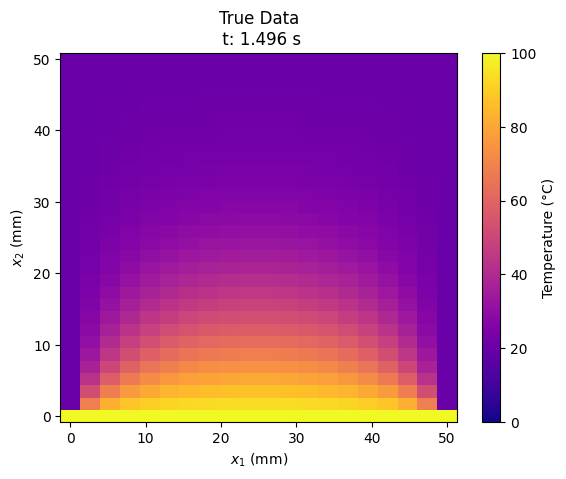

In [3]:
samp_time = len(t_train) // 2 # plot the time in the middle of training

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, heat_data[samp_time+train, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'True Data\n t: {(samp_time+train)*dt:.3f} s')
plt.xlabel('$x_{1}$ (mm)')
plt.ylabel('$x_{2}$ (mm)')
plt.show()

In [4]:
import os
import sys

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from deep_learning import deep_network_core as core, utils
import torch
import torch.nn as nn
from torch.autograd import grad as autograd

In [5]:
# torch.manual_seed(1234)
# np.random.seed(1234)

Tr, Xr, Yr = np.meshgrid(t_train, x_train, y_train)

inpt = np.column_stack((
    Tr.transpose(1, 0, 2).ravel(), # Transpose needed to get in t, x, y order
    Xr.transpose(1, 0, 2).ravel(), 
    Yr.transpose(1, 0, 2).ravel(),
    ))
oupt = heat_data[:train, :, :].ravel()

In [ ]:
class MSE_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.MSELoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

class Huber_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.HuberLoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

class PHYSICS_Loss(core.LOSS):
    # def __init__(self, bounds):
    #     self.bounds = bounds
    
    def __call__(self, target, result, model):
        x = torch.empty((100, 1)).uniform_(0, length).requires_grad_(True)
        y = torch.empty((100, 1)).uniform_(0, length).requires_grad_(True)
        t = torch.empty((100, 1)).uniform_(0, time).requires_grad_(True)
        inp = torch.cat((t, x, y), axis=1)
        zs = model(inp)
        pde = utils.dy_dt(zs, t) - utils.laplacian_2d(zs, x, y) # dz/dt - (ddz/dxx + ddz/dyy)
        return torch.mean(pde**2)

In [7]:
x = torch.empty((100, 1)).uniform_(0, length).requires_grad_(True)
y = torch.empty((100, 1)).uniform_(0, length).requires_grad_(True)
t = torch.empty((100, 1)).uniform_(0, time).requires_grad_(True)
inp = torch.cat((x, y, t), axis=1)

inp.shape

torch.Size([100, 3])

In [8]:
network_nn = core.PINN(3, 1, 64, 3, [(1, MSE_Loss())])

In [9]:
print("Training NN")
network_nn.fit(inpt, oupt, lr=3e-4, epochs=3000)


Training NN
Epoch 1/3000 loss: 1.4e+03
Epoch 300/3000 loss: 3.8e+02
Epoch 600/3000 loss: 30
Epoch 900/3000 loss: 22
Epoch 1200/3000 loss: 19
Epoch 1500/3000 loss: 17
Epoch 1800/3000 loss: 16
Epoch 2100/3000 loss: 14
Epoch 2400/3000 loss: 13
Epoch 2700/3000 loss: 11
Epoch 3000/3000 loss: 9.9


[1411.1851806640625,
 1405.283935546875,
 1399.5977783203125,
 1394.3505859375,
 1389.7415771484375,
 1385.3558349609375,
 1381.1812744140625,
 1377.0194091796875,
 1372.84326171875,
 1368.6070556640625,
 1364.3326416015625,
 1360.0072021484375,
 1355.6077880859375,
 1351.0897216796875,
 1346.43896484375,
 1341.5936279296875,
 1336.530517578125,
 1331.227294921875,
 1325.6685791015625,
 1319.826416015625,
 1313.677978515625,
 1307.20849609375,
 1300.38720703125,
 1293.17626953125,
 1285.596435546875,
 1277.6334228515625,
 1269.263671875,
 1260.4722900390625,
 1251.23046875,
 1241.51123046875,
 1231.272705078125,
 1220.4881591796875,
 1209.15185546875,
 1197.2440185546875,
 1184.725830078125,
 1171.5272216796875,
 1157.621826171875,
 1143.02734375,
 1127.7569580078125,
 1111.811279296875,
 1095.166259765625,
 1077.87060546875,
 1060.0528564453125,
 1041.7398681640625,
 1022.9979858398438,
 1003.8959350585938,
 984.4913330078125,
 964.8546142578125,
 945.10498046875,
 925.4036865234375,


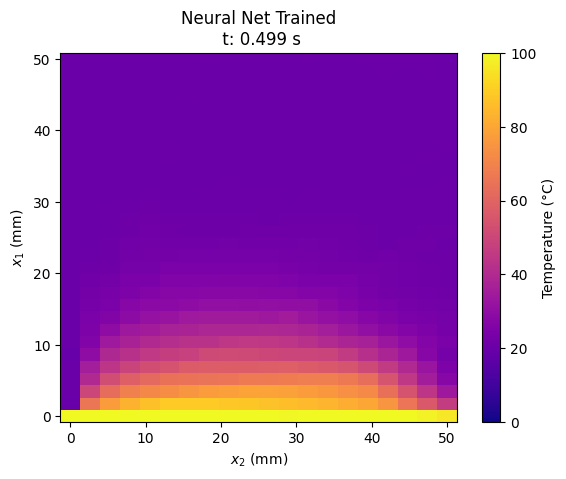

In [79]:
pred_nn_train = network_nn.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_nn_train[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'Neural Net Trained\n t: {samp_time*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

In [80]:
Tr_test, Xr_test, Yr_test = np.meshgrid(t_test, x_train, y_train)

inpt_test = np.column_stack((
    Tr_test.transpose(1, 0, 2).ravel(), # Transpose needed to get in t, x, y order
    Xr_test.transpose(1, 0, 2).ravel(), 
    Yr_test.transpose(1, 0, 2).ravel(),
    ))


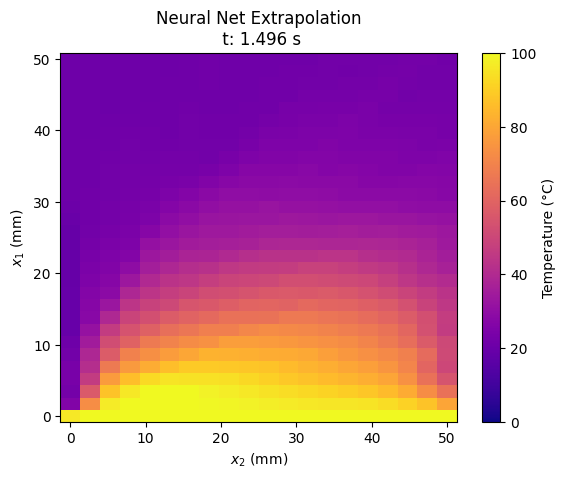

In [81]:

pred_nn_test = network_nn.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_nn_test[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'Neural Net Extrapolation\n t: {(samp_time+train)*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

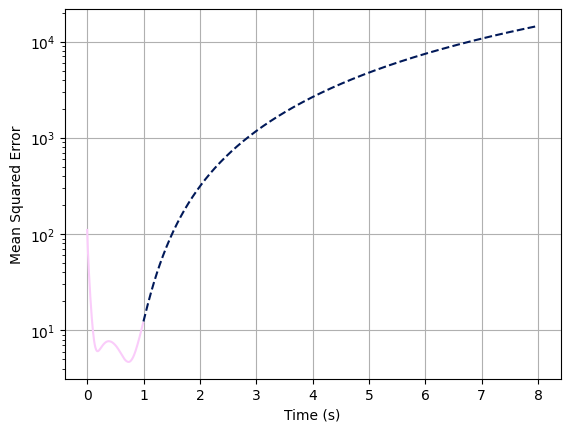

In [67]:
mses_nn_train = []
for i, pred in enumerate(pred_nn_train):
    mses_nn_train.append(mean_squared_error(heat_data[i, :, :], pred))

mses_nn_test = []
for i, pred in enumerate(pred_nn_test):
    mses_nn_test.append(mean_squared_error(heat_data[train+i, :, :], pred))

plt.figure()
plt.semilogy(t_train, mses_nn_train, '-', c=batlow_colors[4])
plt.semilogy(t_test, mses_nn_test, '--', c=batlow_colors[0])
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Time (s)')
plt.title('')
plt.show()

In [14]:
network_pinn = core.PINN(3, 1, 64, 3, [(1, MSE_Loss()), (1, PHYSICS_Loss())])

print("Training PINN")
network_pinn.fit(inpt, oupt, lr=5e-4, epochs=2000)

Training PINN
Epoch 1/2000 loss: 1.4e+03
Epoch 200/2000 loss: 4e+02
Epoch 400/2000 loss: 42
Epoch 600/2000 loss: 37
Epoch 800/2000 loss: 33
Epoch 1000/2000 loss: 31
Epoch 1200/2000 loss: 29
Epoch 1400/2000 loss: 28
Epoch 1600/2000 loss: 27
Epoch 1800/2000 loss: 26
Epoch 2000/2000 loss: 26


[1432.7005615234375,
 1422.708251953125,
 1413.3116455078125,
 1404.5867919921875,
 1396.379638671875,
 1388.626953125,
 1381.2216796875,
 1374.11474609375,
 1367.17041015625,
 1360.1807861328125,
 1353.026611328125,
 1345.6329345703125,
 1337.85009765625,
 1329.6605224609375,
 1321.08447265625,
 1312.0084228515625,
 1302.462646484375,
 1292.36083984375,
 1281.549072265625,
 1270.04931640625,
 1257.867919921875,
 1244.9525146484375,
 1231.2950439453125,
 1216.8944091796875,
 1201.70556640625,
 1185.6993408203125,
 1168.8411865234375,
 1151.1126708984375,
 1132.4603271484375,
 1112.8909912109375,
 1092.4376220703125,
 1071.1583251953125,
 1049.19140625,
 1026.4588623046875,
 1003.0084228515625,
 979.0127563476562,
 954.6435546875,
 930.1067504882812,
 905.666748046875,
 881.53173828125,
 857.9706420898438,
 835.3096923828125,
 813.8765869140625,
 794.1259155273438,
 776.5087280273438,
 761.3897705078125,
 749.06884765625,
 739.6907958984375,
 733.1556396484375,
 729.1782836914062,
 727.

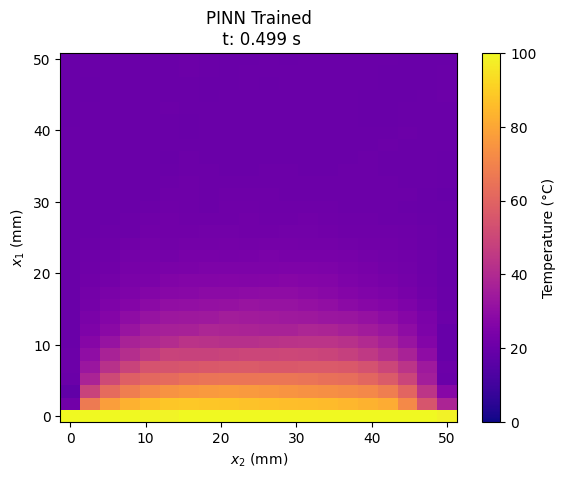

In [52]:
pred_pinn_train = network_pinn.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_pinn_train[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'PINN Trained\n t: {samp_time*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

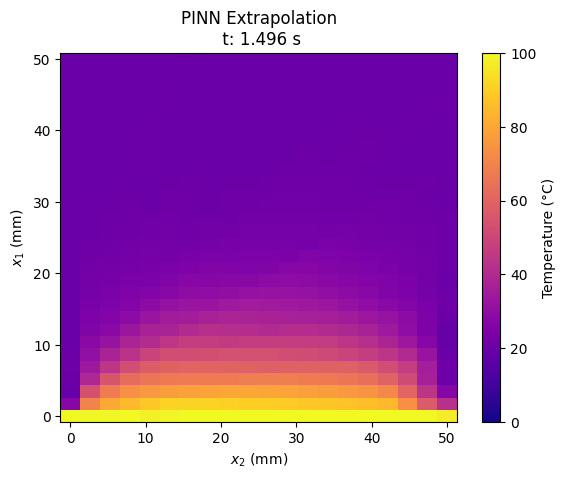

In [55]:
pred_pinn_test = network_pinn.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_pinn_test[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'PINN Extrapolation\n t: {(samp_time+train)*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

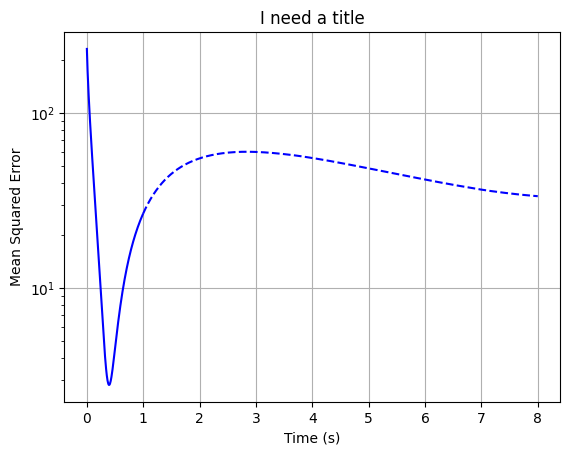

In [56]:
mses_pinn_train = []
for i, pred in enumerate(pred_pinn_train):
    mses_pinn_train.append(mean_squared_error(heat_data[i, :, :], pred))

mses_pinn_test = []
for i, pred in enumerate(pred_pinn_test):
    mses_pinn_test.append(mean_squared_error(heat_data[train+i, :, :], pred))

plt.figure()
plt.semilogy(t_train, mses_pinn_train, 'b-')
plt.semilogy(t_test, mses_pinn_test, 'b--')
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Time (s)')
plt.title('I need a title')
plt.show()

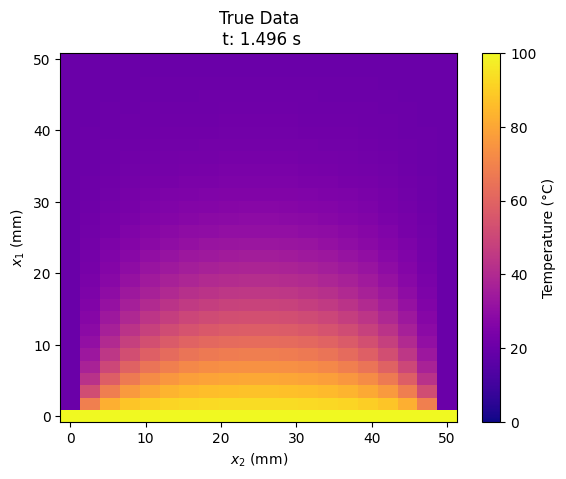

In [18]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, heat_data[(samp_time+train), :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'True Data\n t: {(samp_time+train)*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

In [19]:
network_dgm = core.DGM(3, 1, 128, 4, [(1, MSE_Loss())])
print("Training DGM")
network_dgm.fit(inpt, oupt, lr=3e-3, epochs=1500)

Training DGM
Epoch 1/1500 loss: 1.7e+03
Epoch 150/1500 loss: 3.2e+02
Epoch 300/1500 loss: 82
Epoch 450/1500 loss: 55
Epoch 600/1500 loss: 46
Epoch 750/1500 loss: 40
Epoch 900/1500 loss: 35
Epoch 1050/1500 loss: 31
Epoch 1200/1500 loss: 28
Epoch 1350/1500 loss: 26
Epoch 1500/1500 loss: 25


[1723.1812744140625,
 1577.422119140625,
 1444.40234375,
 1323.9619140625,
 1215.94970703125,
 1120.1767578125,
 1036.417724609375,
 964.4013671875,
 903.7735595703125,
 854.0650024414062,
 814.6617431640625,
 784.7614135742188,
 763.3377075195312,
 749.136474609375,
 740.6973876953125,
 736.4367065429688,
 734.7770385742188,
 734.2946166992188,
 733.810546875,
 732.4550170898438,
 729.6669311523438,
 725.168701171875,
 718.926513671875,
 711.095703125,
 701.9625244140625,
 691.888671875,
 681.2692260742188,
 670.4868774414062,
 659.8904418945312,
 649.7727661132812,
 640.3572998046875,
 631.7894287109375,
 624.1520385742188,
 617.451904296875,
 611.645263671875,
 606.6358032226562,
 602.3037109375,
 598.5175170898438,
 595.144287109375,
 592.0575561523438,
 589.1437377929688,
 586.3087768554688,
 583.4801025390625,
 580.6089477539062,
 577.669677734375,
 574.6550903320312,
 571.5721435546875,
 568.4395751953125,
 565.283203125,
 562.128662109375,
 558.9976806640625,
 555.9043579101562

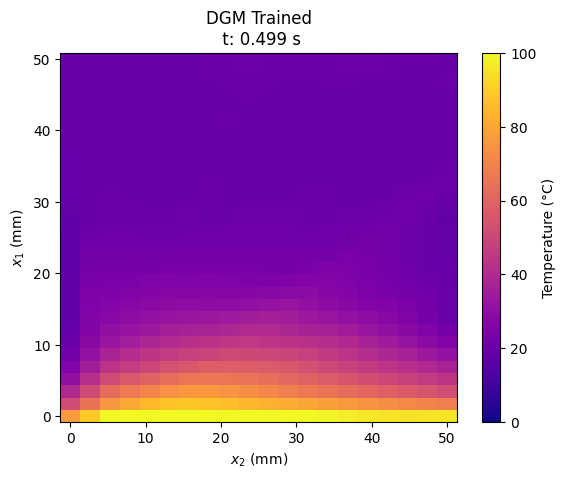

In [73]:
pred_dgm_train = network_dgm.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))


fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_dgm_train[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'DGM Trained\n t: {(samp_time)*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

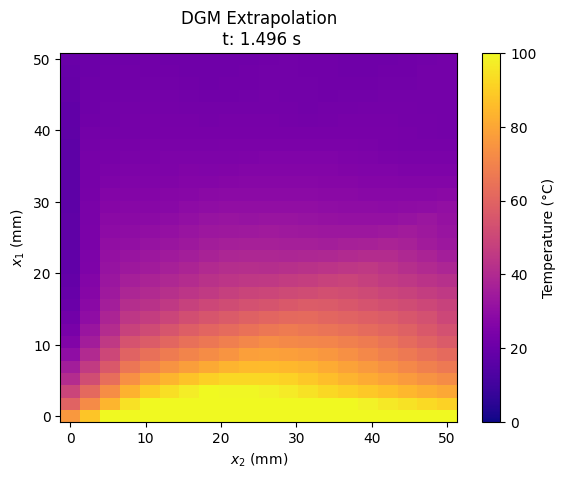

In [74]:
pred_dgm_test = network_dgm.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_dgm_test[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'DGM Extrapolation\n t: {(samp_time+train)*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

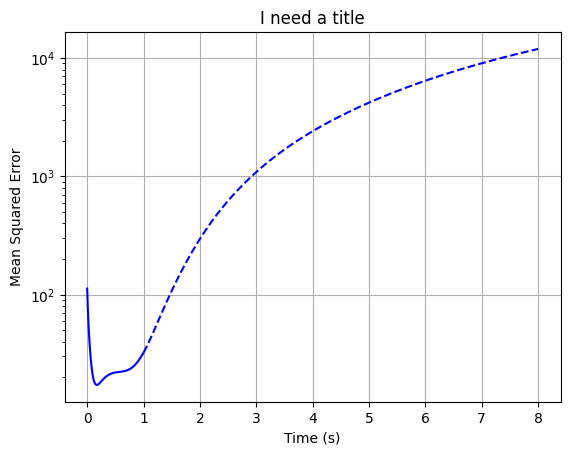

In [76]:

mses_dgm_train = []
for i, pred in enumerate(pred_dgm_train):
    mses_dgm_train.append(mean_squared_error(heat_data[i, :, :], pred))

mses_dgm_test = []
for i, pred in enumerate(pred_dgm_test):
    mses_dgm_test.append(mean_squared_error(heat_data[train+i, :, :], pred))

plt.figure()
plt.semilogy(t_train, mses_dgm_train, 'b-')
plt.semilogy(t_test, mses_dgm_test, 'b--')
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Time (s)')
plt.title('I need a title')
plt.show()

In [23]:
network_pi_dgm = core.DGM(3, 1, 128, 4, [(1, MSE_Loss()), (1, PHYSICS_Loss())])
print("Training PI-DGM")
network_pi_dgm.fit(inpt, oupt, lr=3e-3, epochs=1500)

Training PI-DGM
Epoch 1/1500 loss: 1.3e+03
Epoch 150/1500 loss: 3.8e+02
Epoch 300/1500 loss: 1.7e+02
Epoch 450/1500 loss: 83
Epoch 600/1500 loss: 63
Epoch 750/1500 loss: 53
Epoch 900/1500 loss: 47
Epoch 1050/1500 loss: 44
Epoch 1200/1500 loss: 43
Epoch 1350/1500 loss: 41
Epoch 1500/1500 loss: 41


[1297.07275390625,
 1180.3291015625,
 1077.414306640625,
 988.4656372070312,
 913.4777221679688,
 852.2388305664062,
 804.26123046875,
 768.660888671875,
 744.110107421875,
 728.7744750976562,
 720.352783203125,
 716.3982543945312,
 714.5086669921875,
 712.8289184570312,
 709.9899291992188,
 705.2138671875,
 698.2457885742188,
 689.152587890625,
 678.2776489257812,
 666.2734375,
 653.615234375,
 640.9531860351562,
 628.7921142578125,
 617.5000610351562,
 607.4110717773438,
 598.66357421875,
 591.2709350585938,
 585.2140502929688,
 580.3172607421875,
 576.2859497070312,
 572.843505859375,
 569.8771362304688,
 566.9905395507812,
 564.0875854492188,
 561.01318359375,
 557.8568725585938,
 554.4279174804688,
 550.7718505859375,
 546.9707641601562,
 543.3947143554688,
 539.5309448242188,
 535.9412841796875,
 532.64501953125,
 529.37158203125,
 526.3587646484375,
 523.4039306640625,
 520.8396606445312,
 518.6256713867188,
 516.149658203125,
 513.6694946289062,
 511.189697265625,
 508.92669677

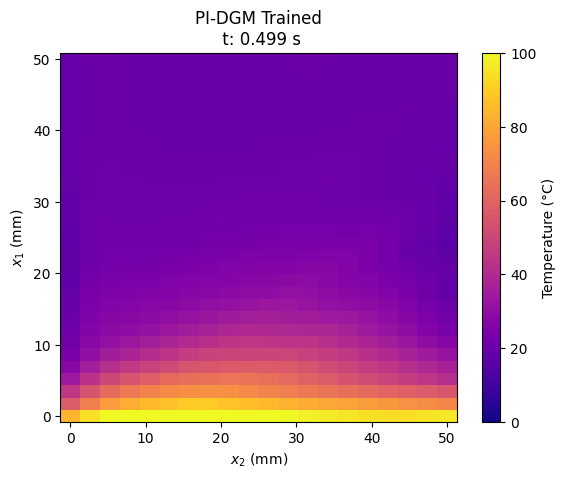

In [82]:
pred_pi_dgm_train = network_pi_dgm.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_pi_dgm_train[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'PI-DGM Trained\n t: {(samp_time)*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

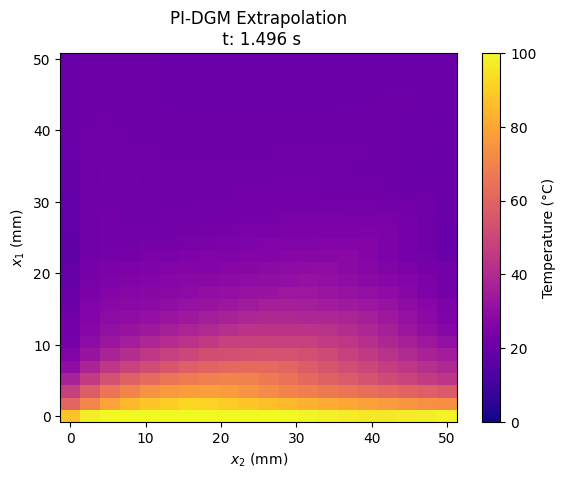

In [84]:
pred_pi_dgm_test = network_pi_dgm.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

fig, axis = plt.subplots()
pcm = axis.pcolormesh(y_train, x_train, pred_pi_dgm_test[samp_time, :, :], cmap='plasma', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f'PI-DGM Extrapolation\n t: {(samp_time+train)*dt:.3f} s')
plt.xlabel('$x_{2}$ (mm)')
plt.ylabel('$x_{1}$ (mm)')
plt.show()

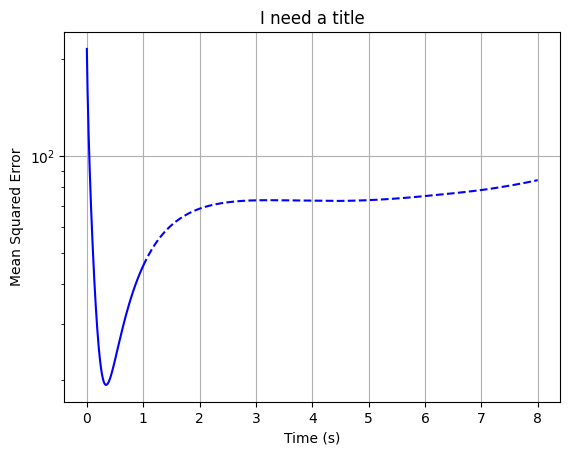

In [85]:
mses_pi_dgm_train = []
for i, pred in enumerate(pred_pi_dgm_train):
    mses_pi_dgm_train.append(mean_squared_error(heat_data[i, :, :], pred))

mses_pi_dgm_test = []
for i, pred in enumerate(pred_pi_dgm_test):
    mses_pi_dgm_test.append(mean_squared_error(heat_data[train+i, :, :], pred))

plt.figure()
plt.semilogy(t_train, mses_pi_dgm_train, 'b-')
plt.semilogy(t_test, mses_pi_dgm_test, 'b--')
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Time (s)')
plt.title('I need a title')
plt.show()

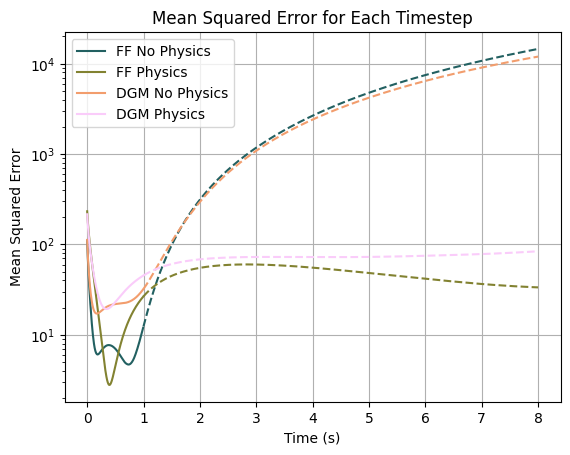

In [92]:
plt.figure()
plt.semilogy(t_train, mses_nn_train, '-', c=batlow_colors[1])
plt.semilogy(t_train, mses_pinn_train, '-', c=batlow_colors[2])
plt.semilogy(t_train, mses_dgm_train, '-', c=batlow_colors[3])
plt.semilogy(t_train, mses_pi_dgm_train, '-', c=batlow_colors[4])
plt.semilogy(t_test, mses_nn_test, '--', c=batlow_colors[1])
plt.semilogy(t_test, mses_pinn_test, '--', c=batlow_colors[2])
plt.semilogy(t_test, mses_dgm_test, '--', c=batlow_colors[3])
plt.semilogy(t_test, mses_pi_dgm_test, '--', c=batlow_colors[4])
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Time (s)')
plt.title('Mean Squared Error for Each Timestep')
plt.legend(['FF No Physics', 'FF Physics', 'DGM No Physics', 'DGM Physics'])
plt.show()